# Example 00 - The Official Sig53 Dataset
This notebook walks through an example of how the official Sig53 dataset can be instantiated and analyzed.

---

## Import Libraries
First, import all the necessary public libraries as well as a few classes from the `torchsig` toolkit.

In [1]:
from torchsig.utils.visualize import IQVisualizer, SpectrogramVisualizer
from torchsig.datasets.sig53 import Sig53
from torchsig.utils.dataset import SignalDataset
from torchsig.datasets import conf
from torch.utils.data import DataLoader
from torch.nn import Identity
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import os

from torchsig.datasets.datamodules import Sig53DataModule
from torchsig.transforms.target_transforms import DescToClassIndexSNR

### Instantiate Sig53 Dataset
To instantiate the Sig53 dataset, several parameters are given to the imported `Sig53DataModule` class. These paramters are:
- `root` ~ A string to specify the root directory of where to instantiate and/or read an existing Sig53 dataset
- `impaired` ~ A boolean to specify if the Sig53 dataset should be the clean version or the impaired version
- `qa` - A boolean to specify whether to generate a small subset of Sig53 (True), or the full dataset (False), default is True
- `eb_no` - A boolean specifying if the SNR should be defined as Eb/No if True (making higher order modulations more powerful) or as Es/No if False (Defualt: False)
- `transform` ~ Optionally, pass in any data transforms here if the dataset will be used in an ML training pipeline
- `target_transform` ~ Optionally, pass in any target transforms here if the dataset will be used in an ML training pipeline

A combination of the `impaired` and the `qa` booleans determines which of the four (4) distinct Sig53 datasets will be instantiated:
| `impaired` | `qa` | Result |
| ---------- | ---- | ------- |
| `False` | `False` | Clean datasets of train=1.06M examples and val=5.3M examples |
| `False` | `True` | Clean datasets of train=10600 examples and val=1060 examples |
| `True` | `False` | Impaired datasets of train=1.06M examples and val=5.3M examples |
| `True` | `True` | Impaired datasets of train=10600 examples and val=1060 examples |

The final option of the impaired validation set is the dataset to be used when reporting any results with the official Sig53 dataset.

In [2]:
# Generate Sig53 DataModule
root = "./wideband_sig53"
class_list = list(Sig53._idx_to_name_dict.values())

datamodule = Sig53DataModule(
    root=root,
    impaired=False,
    transform=Identity(),
    target_transform=DescToClassIndexSNR(class_list)
)
datamodule.prepare_data()
datamodule.setup("fit")
sig53 = datamodule.train

# Retrieve a sample and print out information
idx = np.random.randint(len(sig53))
data, (label, snr) = sig53[idx]
print("Dataset length: {}".format(len(sig53)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))
print("Label Class: {}".format(Sig53.convert_idx_to_name(label)))
print("SNR: {}".format(snr))

Using Sig53CleanTrainQAConfig for train.
Using Sig53CleanValQAConfig for val.


84it [02:56,  2.10s/it]                        


9it [00:17,  1.95s/it]                       

Dataset length: 10600
Data shape: (4096,)
Label Index: 5
Label Class: 8pam
SNR: 100.0


## Plot Subset to Verify
The `IQVisualizer` and the `SpectrogramVisualizer` can be passed a `Dataloader` and plot visualizations of the dataset. The `batch_size` of the `DataLoader` determines how many examples to plot for each iteration over the visualizer. Note that the dataset itself can be indexed and plotted sequentially using any familiar python plotting tools as an alternative plotting method to using the `torchsig` `Visualizer` as shown below.

In [3]:
# For plotting, omit the SNR values
class DataWrapper(SignalDataset):
    def __init__(self, dataset):
        self.dataset = dataset
        super().__init__(dataset)

    def __getitem__(self, idx):
        x, (y, z) = self.dataset[idx]
        return x, y

    def __len__(self) -> int:
        return len(self.dataset)


plot_dataset = DataWrapper(sig53)

data_loader = DataLoader(dataset=plot_dataset, batch_size=16, shuffle=True)

# Transform the plotting titles from the class index to the name
def target_idx_to_name(tensor: np.ndarray) -> list:
    batch_size = tensor.shape[0]
    label = []
    for idx in range(batch_size):
        label.append(Sig53.convert_idx_to_name(int(tensor[idx])))
    return label


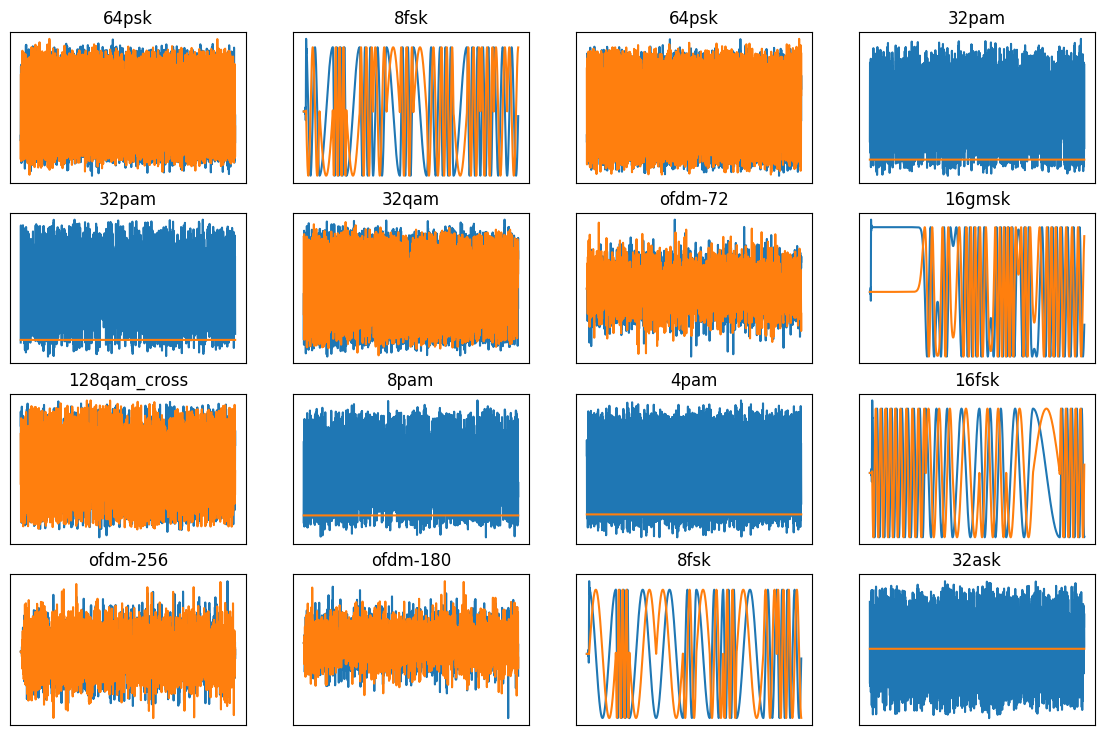

In [4]:
visualizer = IQVisualizer(
    data_loader=data_loader,
    visualize_transform=None,
    visualize_target_transform=target_idx_to_name,
)

for figure in iter(visualizer):
    figure.set_size_inches(14, 9)
    # plt.savefig(f"{figure_dir}/00_iq_data.png")
    break

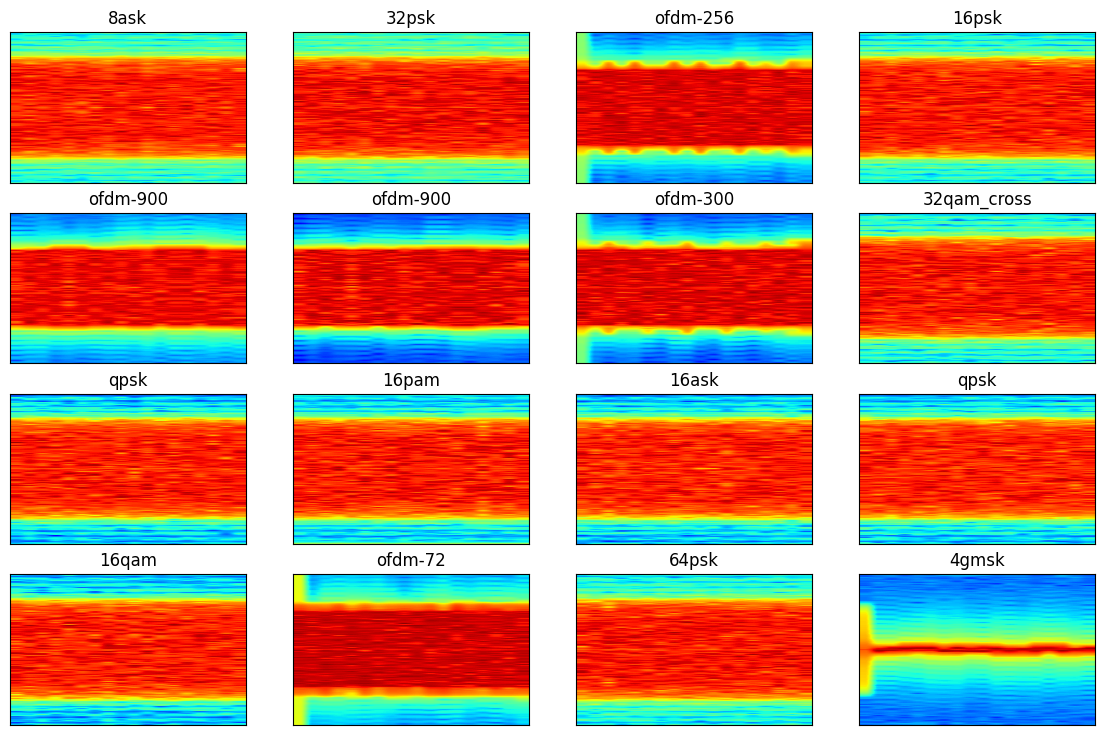

In [5]:
# Repeat but plot the spectrograms for a new random sampling of the data
visualizer = SpectrogramVisualizer(
    data_loader=data_loader,
    nfft=1024,
    visualize_transform=None,
    visualize_target_transform=target_idx_to_name,
)

for figure in iter(visualizer):
    figure.set_size_inches(14, 9)
    break

## Analyze Dataset
The dataset can also be analyzed at the macro level for details such as the distribution of classes and SNR values. This exercise is performed below to show the nearly uniform distribution across each.

In [6]:
# Loop through the dataset recording classes and SNRs
class_counter_dict = {
    class_name: 0 for class_name in list(Sig53._idx_to_name_dict.values())
}
all_snrs = []

for idx in tqdm(range(len(sig53))):
    data, (modulation, snr) = sig53[idx]
    class_counter_dict[Sig53.convert_idx_to_name(modulation)] += 1
    all_snrs.append(snr)


# Plot the distribution of classes
class_names = list(class_counter_dict.keys())
num_classes = list(class_counter_dict.values())

100%|██████████| 10600/10600 [00:00<00:00, 30859.20it/s]


Text(0.5, 1.0, 'Class Distribution Pie Chart')

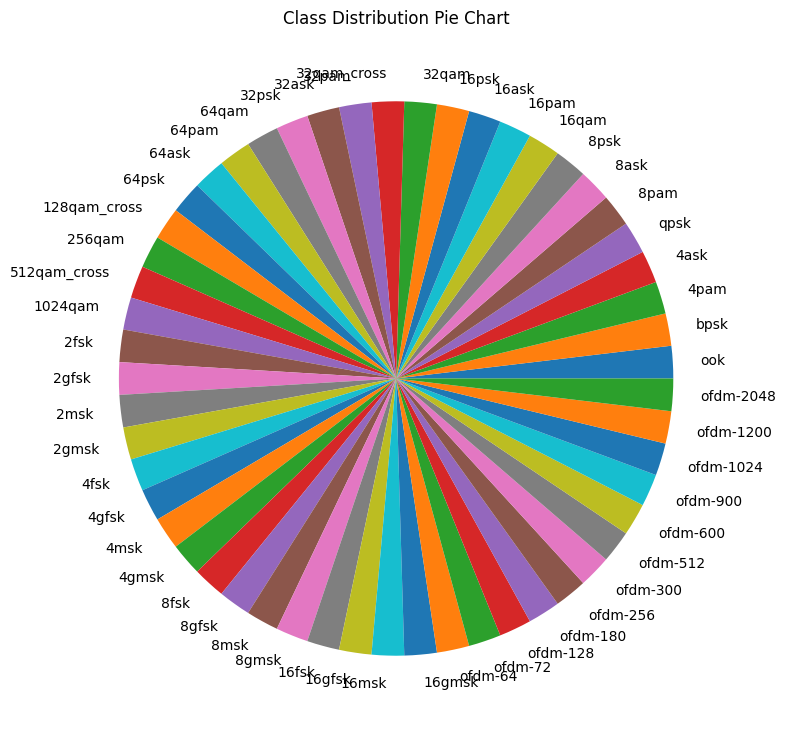

In [7]:
plt.figure(figsize=(9, 9))
plt.pie(num_classes, labels=class_names)
plt.title("Class Distribution Pie Chart")

Text(0, 0.5, 'Counts')

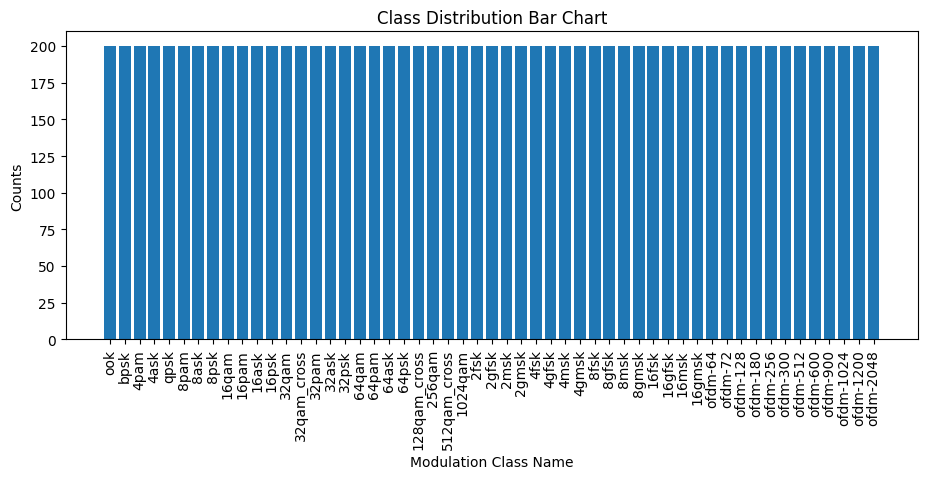

In [8]:
plt.figure(figsize=(11, 4))
plt.bar(class_names, num_classes)
plt.xticks(rotation=90)
plt.title("Class Distribution Bar Chart")
plt.xlabel("Modulation Class Name")
plt.ylabel("Counts")

Text(0, 0.5, 'Counts')

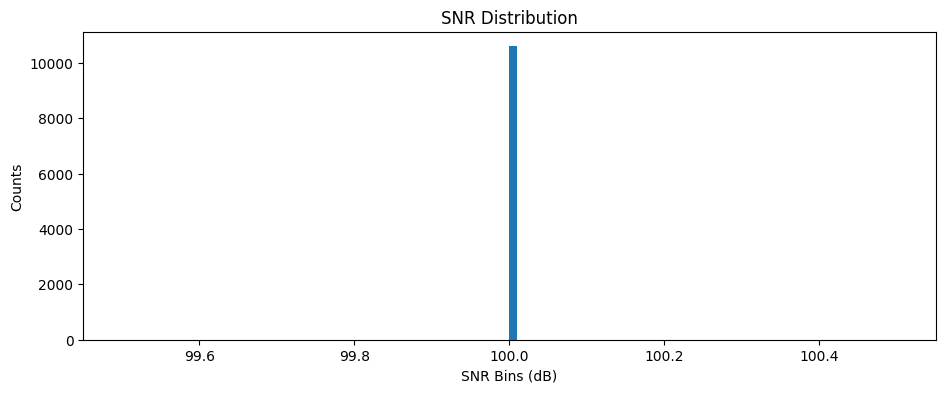

In [9]:
# Plot the distribution of SNR values
plt.figure(figsize=(11, 4))
plt.hist(x=all_snrs, bins=100)
plt.title("SNR Distribution")
plt.xlabel("SNR Bins (dB)")
plt.ylabel("Counts")